# Dirichlet prior

A Dirichlet prior is conjugate for the categorical and multinomial distributions.

The Dirichlet distribution is a distribution over distributions.  Parameters are $(\alpha_i)_{i=1}^n$ and the variable space is the simplex $\{ (p_i)_{i=1}^n : p_i\geq 0, \ \sum_i p_i = 1 \}$.  Then
$$ p\big((p_i)\big|(\alpha_i)\big) =
\frac{\Gamma(\alpha_0)}{\prod_i \Gamma(\alpha_i)} \prod_i p_i^{\alpha_i-1}, $$
where by convention $\alpha_0 = \sum_i \alpha_i$.

The multinomial distribution is parameterised by $(p_i)$ in the simplex, and have variables $(n_i)$ the count of event $i$.  Then
$$ p\big( (n_i) \big| (p_i) \big) = \frac{N!}{\prod n_i!} \prod_i p_i^{n_i}, $$
where $N = \sum_i n_i$.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.special
import scipy.integrate
import numpy as np
import corner
import emcee

In [2]:
preal = np.asarray([5,6,7,8])
preal = preal / np.sum(preal)

In [3]:
data = np.random.multinomial(100, preal)
alpha_post = data

In [4]:
alpha_prior = [1] * len(preal)

In [5]:
alpha = alpha_post + alpha_prior

In [6]:
samples = np.random.dirichlet(alpha, size=10000)

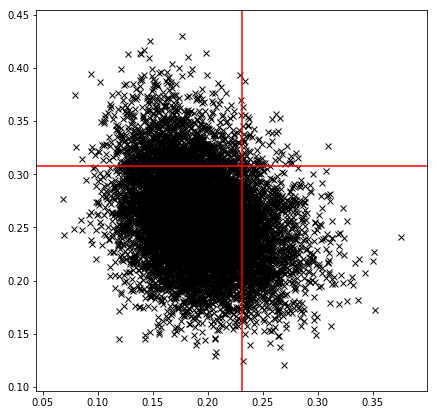

In [7]:
def plot_slice(ax, a, b, samples):
    ax.scatter(samples[:,a], samples[:,b], marker="x", color="black", linewidth=1)
    xr, yr = ax.get_xlim(), ax.get_ylim()
    x, y = preal[a], preal[b]
    ax.plot([0,1], [y,y], color="red")
    ax.plot([x,x], [0,1], color="red")
    ax.set(xlim=xr, ylim=yr)

fig, ax = plt.subplots(figsize=(7,7))
plot_slice(ax, 1, 3, samples)

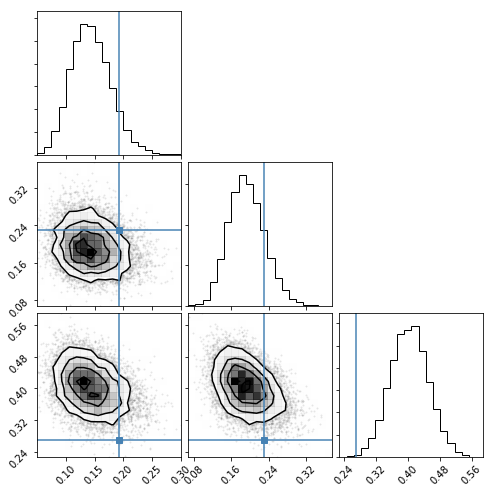

In [8]:
fig = corner.corner(samples[:,:3], truths=preal)

In [9]:
def data_log_likelihood(p, data):
    N = np.sum(data)
    ll = scipy.special.gammaln(N+1) - np.sum(scipy.special.gammaln(data+1))
    ll += np.sum(data * np.log(p))
    if not np.isfinite(ll):
        raise AssertionError(p, data)
    return ll

def log_likelihood(p, data):
    q = 1 - np.sum(p)
    if np.any(p < 0) or np.any(p > 1) or q < 0:
        return -np.inf
    pp = np.empty(len(p)+1)
    pp[:len(p)] = p
    pp[-1] = q
    # Assume flat prior
    return data_log_likelihood(pp, data)

In [10]:
nwalkers = 10
#p0 = np.random.rand(3 * nwalkers).reshape((nwalkers, 3))
# More suitable starting point
p0 = np.random.dirichlet([1]*4, size=nwalkers)[:, :3]

In [11]:
sampler = emcee.EnsembleSampler(nwalkers, 3, log_likelihood, args=(data,))

In [12]:
pos, prob, state = sampler.run_mcmc(p0, 1000)
sampler.reset()

In [13]:
_ = sampler.run_mcmc(pos, 20000)

In [14]:
samples = sampler.flatchain

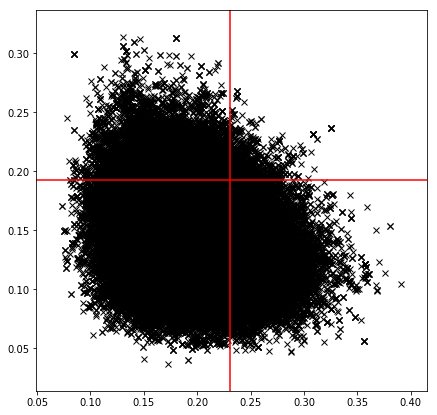

In [15]:
fig, ax = plt.subplots(figsize=(7,7))
plot_slice(ax, 1, 0, samples)

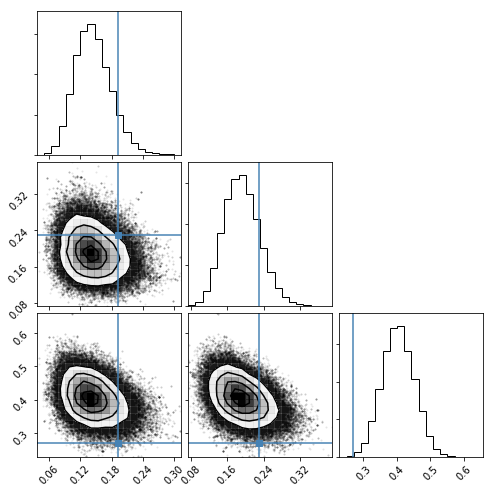

In [16]:
fig = corner.corner(samples, truths=preal)

# With pymc3

In [17]:
import pymc3 as pm

In [20]:
data

array([14, 19, 41, 26])

In [83]:
with pm.Model() as model:
    prob = pm.Dirichlet("prob", a=np.asarray([1] * 4))#, transform=None)
    obs = pm.Multinomial("n", n=np.sum(data), p=prob, observed=data)
    
    trace = pm.sample(10000, tune=500)

C:\Users\MattUser\Anaconda3\lib\site-packages\theano\tensor\basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████████████████████████████| 10500/10500 [00:10<00:00, 1022.91it/s]


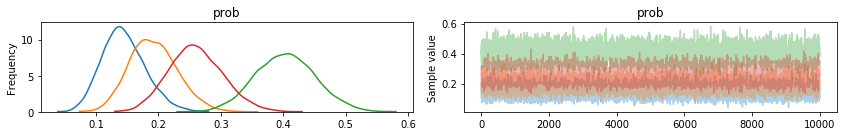

In [84]:
axes = pm.traceplot(trace)

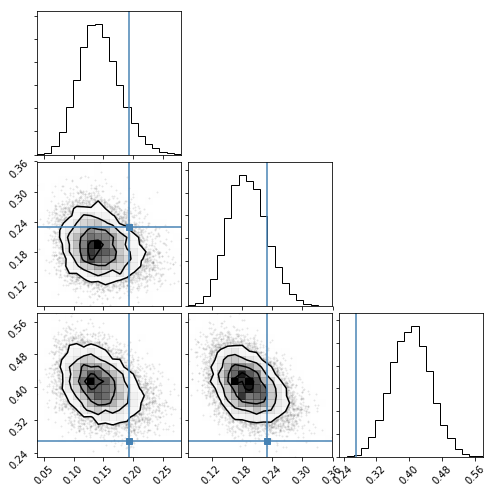

In [85]:
samples = trace.get_values("prob")
fig = corner.corner(samples[:,:3], truths=preal)

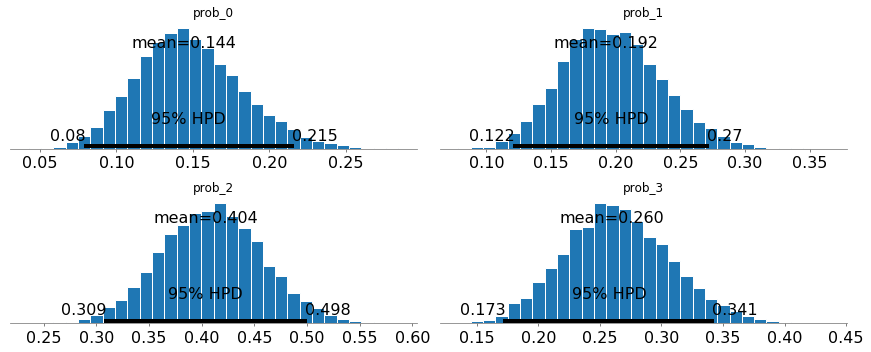

In [87]:
axes = pm.plot_posterior(trace)

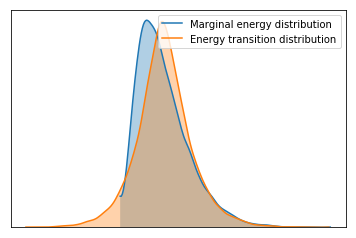

In [88]:
pm.energyplot(trace)